In [2]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using NearestNeighbors
include("LHI_Navier-stokes.jl")
using DoubleFloats
using Profile
using StatsBase

In [84]:
μ = 1.0
ρ = 1.0
@variables ϵ r x₁ x₂ u1 v1 u2 v2 ;
ϕ1 = r^7
ϕ2 = r^3

ϕ1 = substitute(ϕ1, r=>sqrt(x₁^2 + x₂^2))
ϕ2 = substitute(ϕ2, r=>sqrt(x₁^2 + x₂^2))

∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))

Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ1)) ∂₁(∂₂(ϕ1)) 0; ∂₁(∂₂(ϕ1)) -∂₁(∂₁(ϕ1)) 0; 0 0 ϕ2])

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1x(x) =  -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3])  #+  u1*∂₁(x[1]) + v1*∂₂(x[1])
λ2x(x) =  -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3]) #+ u1*∂₁(x[2]) + v1*∂₂(x[2])
λ3x(x) = x[1]
λ4x(x) = x[2]

λ1y(x) =  -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3]) #- u2*∂₁(x[1]) - v2*∂₂(x[1])
λ2y(x) =  -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3]) #-u2*∂₁(x[2]) - v2*∂₂(x[2])
λ3y(x) = x[1]
λ4y(x) = x[2]

display(Φ_div)

F_A = construct_kernel_array(Φ_div,[λu,λv,λ1x,λ2x,λ3x,λ4x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
compile_kernel_array_NS(F_A,:F_A)


F_B = construct_kernel_array(Φ_div,[λ1x,λ2x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
display(F_B)
compile_kernel_array_NS(F_B,:F_B)

P_list2D = generate_2D2_div_free_poly_basis(2)
P_list1D = generate_2D1_poly_basis(2)
P_list = []
for p2 in P_list2D
    append!(P_list, [vcat(p2,Num(0.0))])
end
for p1 in P_list1D[2:end]
    append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
end
#display(P_list)
N_poly = length(P_list)
F_PA = apply_functionals_to_polynomials([λu,λv,λ1x,λ2x,λ3x,λ4x],P_list)
#display(F_PA)
compile_polynomials_NS(F_PA,:F_PA)

F_PB = apply_functionals_to_polynomials([λ1x,λ2x],P_list)
#display(F_PB)
compile_polynomials_NS(F_PB,:F_PB)


println("done")
F_B11(1e-30,1e-30,0,0,0,0,1)

3×3 Matrix{Num}:
 -7(sqrt(x₁^2 + x₂^2)^5) - 35(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)  …                    0
                            35x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                       0
                                                        0     sqrt(x₁^2 + x₂^2)^3

2×6 Matrix{Num}:
  (105.0(x₂^4) + 105.0(sqrt(x₁^2 + x₂^2)^4) + 630.0(x₂^2)*(sqrt(x₁^2 + x₂^2)^2)) / sqrt(x₁^2 + x₂^2) + (35.0(sqrt(x₁^2 + x₂^2)^4) + 105.0(x₁^2)*(x₂^2) + 105.0(x₁^2)*(sqrt(x₁^2 + x₂^2)^2) + 105.0(x₂^2)*(sqrt(x₁^2 + x₂^2)^2)) / sqrt(x₁^2 + x₂^2)  …  (-105.0x₂*(x₁^3) - 315.0x₁*x₂*(sqrt(x₁^2 + x₂^2)^2)) / sqrt(x₁^2 + x₂^2) + (-105.0x₁*(x₂^3) - 315.0x₁*x₂*(sqrt(x₁^2 + x₂^2)^2)) / sqrt(x₁^2 + x₂^2)
 (-105.0x₂*(x₁^3) - 315.0x₁*x₂*(sqrt(x₁^2 + x₂^2)^2)) / sqrt(x₁^2 + x₂^2) + (-105.0x₁*(x₂^3) - 315.0x₁*x₂*(sqrt(x₁^2 + x₂^2)^2)) / sqrt(x₁^2 + x₂^2)                                                                                                     (105.0(x₁^4) + 105.0(sqrt(x₁^2 + x₂^2)^4) + 630.0(x₁^2)*(sqrt(x₁^2 + x₂^2)^2)) / sqrt(x₁^2 + x₂^2) + (35.0(sqrt(x₁^2 + x₂^2)^4) + 105.0(x₁^2)*(x₂^2) + 105.0(x₁^2)*(sqrt(x₁^2 + x₂^2)^2) + 105.0(x₂^2)*(sqrt(x₁^2 + x₂^2)^2)) / sqrt(x₁^2 + x₂^2)

done


1.7324116139070413e-87

2×76 Matrix{Float64}:
 0.0  0.0        0.0       0.0       …  1.0       1.0       1.0       1.0
 0.0  0.0526316  0.105263  0.157895     0.842105  0.894737  0.947368  1.0

[0.0, 0.0]
[0.0, 1.0]
[1.0, 0.0]
[1.0, 1.0]


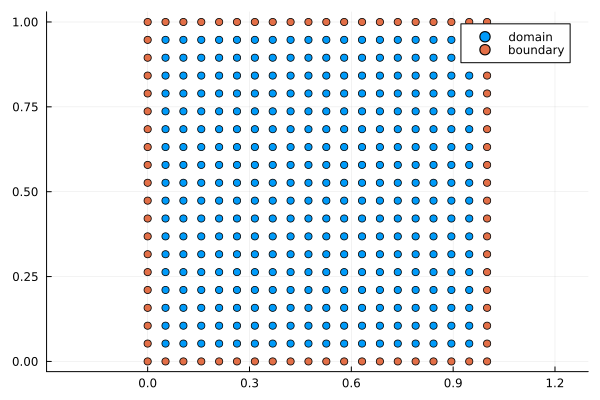

In [101]:
# create points 
N_side = 20
I_points, B_points = generate_2D_equally_spaced_points(N_side)
L_points = I_points 

#all_points = [domain_p boundary_p]
println(B_points[:,1])
println(B_points[:,N_side])
println(B_points[:,3*N_side-3])
println(B_points[:,4*N_side-4])
#B_points = B_points[:, setdiff(1:end,[1,N_side,4*N_side-4,3*N_side-3])]
All_points = hcat(I_points, B_points)
N_I = size(I_points)[2]
N_B = size(B_points)[2]
N_tot = N_I + N_B 
display(B_points)
scatter(I_points[1,:],I_points[2,:],label="domain",aspect_ratio = :equal)
scatter!(B_points[1,:],B_points[2,:],label="boundary")

In [97]:
@variables x y t;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))
dt(exprs) = simplify(expand_derivatives(Differential(t)(exprs)))
u = -y*sin((x^2 + y^2)sin(t^2+1))
v = x*sin((x^2 + y^2)sin(t^2+1))
p = sin(x-y+t)

display(dx(u)+dy(v))
f1 = -(μ/ρ)*(dx(dx(u)) + dy(dy(u))) + dx(p)/ρ + dt(u)
f2 = -(μ/ρ)*(dx(dx(v)) + dy(dy(v))) + dy(p)/ρ + dt(v)
display(f1)
display(f2)
f1 = eval(build_function(f1,x,y,t))
f2 = eval(build_function(f2,x,y,t))
true_v1 = eval(build_function(u,x,y,t))
true_v2 = eval(build_function(v,x,y,t))
true_p = eval(build_function(p,x,y,t))
f1(12,2,1)
function generate_g(B_points)
    return t -> vcat(true_v1.(B_points[1,:],B_points[2,:],t),true_v2.(B_points[1,:],B_points[2,:],t))
end
function generate_f(I_points)
    return t -> vcat(f1.(I_points[1,:],I_points[2,:],t),f2.(I_points[1,:],I_points[2,:],t))
end
g1 = generate_g(B_points)
f =  generate_f(I_points)

0

8.0y*sin(1 + t^2)*cos((x^2 + y^2)*sin(1 + t^2)) + cos(t + x - y) - 4.0(y^3)*(sin(1 + t^2)^2)*sin((x^2 + y^2)*sin(1 + t^2)) - 4.0y*(x^2)*(sin(1 + t^2)^2)*sin((x^2 + y^2)*sin(1 + t^2)) - 2t*y*(x^2 + y^2)*cos(1 + t^2)*cos((x^2 + y^2)*sin(1 + t^2))

4.0(x^3)*(sin(1 + t^2)^2)*sin((x^2 + y^2)*sin(1 + t^2)) + 4.0x*(y^2)*(sin(1 + t^2)^2)*sin((x^2 + y^2)*sin(1 + t^2)) + 2t*x*(x^2 + y^2)*cos(1 + t^2)*cos((x^2 + y^2)*sin(1 + t^2)) - cos(t + x - y) - 8.0x*sin(1 + t^2)*cos((x^2 + y^2)*sin(1 + t^2))

#2103 (generic function with 1 method)

In [109]:
@variables x y;
dx(exprs) = simplify(expand_derivatives(Differential(x)(exprs)))
dy(exprs) = simplify(expand_derivatives(Differential(y)(exprs)))

u = -y*sin(x^2 + y^2)
v = x*sin(x^2 + y^2)
p = sin(x-y)

#u = 20*x*y^3
#v = 5*x^4 - 5*y^4
#p = 60*x*x*y - 20*y*y*y 
display(dx(u)+dy(v))
fu = -(μ/ρ)*(dx(dx(u)) + dy(dy(u))) + dx(p)/ρ
fv = -(μ/ρ)*(dx(dx(v)) + dy(dy(v))) + dy(p)/ρ
display(f1)
display(f2)
fu = eval(build_function(fu,x,y))
fv = eval(build_function(fv,x,y))
true_u = eval(build_function(u,x,y))
true_v = eval(build_function(v,x,y))

function gu(x,y)
    """
    if abs(y-1) < 1e-10 
        return 1#-(0.5-x)^2 + 0.25
    else
        return 0.0
    end
    """
    return true_v1(x,y)
end
gv(x,y) = true_v2(x,y)
gu(0.9,1)
true_v1(1,2)

0

#2115 (generic function with 1 method)

#2117 (generic function with 1 method)

1.917848549326277

In [103]:
radius = 2.01*1.45/(N_side-1)
All_tree = KDTree(All_points,Euclidean(),leafsize = 3)
neigbours = inrange(All_tree, I_points, radius, true)
Neighbours = Vector{Tuple{Vector{Int64},Vector{Int64},Vector{Int64}}}()
s = 0
max_neighbours = 0
for i in 1:N_I
    I_lst = Vector{Int64}()
    L_lst = Vector{Int64}()
    B_lst = Vector{Int64}()
    
    for idx in neigbours[i]
        if idx <= N_I
            append!(I_lst,idx)
            append!(L_lst,idx)
        else
            append!(B_lst,idx-N_I)
        end
    end
    #println(I_lst,L_lst,B_lst)
    L_lst = filter(x -> x != i,I_lst)
    s =s+length(I_lst)+length(L_lst)+length(B_lst)
    append!(Neighbours,[(I_lst,L_lst,B_lst)])
    if max_neighbours < length(vcat(I_lst,L_lst,B_lst))
         max_neighbours = length(vcat(I_lst,L_lst,B_lst))
    end
end
println(max_neighbours)
(Neighbours)

49


324-element Vector{Tuple{Vector{Int64}, Vector{Int64}, Vector{Int64}}}:
 ([1, 2, 3, 19, 20, 21, 37, 38, 39], [2, 3, 19, 20, 21, 37, 38, 39], [1, 2, 3, 4, 21, 23, 25])
 ([1, 2, 3, 4, 19, 20, 21, 22, 37, 38, 39, 40], [1, 3, 4, 19, 20, 21, 22, 37, 38, 39, 40], [1, 2, 3, 4, 5, 21, 23, 25])
 ([1, 2, 3, 4, 5, 19, 20, 21, 22, 23, 37, 38, 39, 40, 41], [1, 2, 4, 5, 19, 20, 21, 22, 23, 37, 38, 39, 40, 41], [2, 3, 4, 5, 6])
 ([2, 3, 4, 5, 6, 20, 21, 22, 23, 24, 38, 39, 40, 41, 42], [2, 3, 5, 6, 20, 21, 22, 23, 24, 38, 39, 40, 41, 42], [3, 4, 5, 6, 7])
 ([3, 4, 5, 6, 7, 21, 22, 23, 24, 25, 39, 40, 41, 42, 43], [3, 4, 6, 7, 21, 22, 23, 24, 25, 39, 40, 41, 42, 43], [4, 5, 6, 7, 8])
 ([4, 5, 6, 7, 8, 22, 23, 24, 25, 26, 40, 41, 42, 43, 44], [4, 5, 7, 8, 22, 23, 24, 25, 26, 40, 41, 42, 43, 44], [5, 6, 7, 8, 9])
 ([5, 6, 7, 8, 9, 23, 24, 25, 26, 27, 41, 42, 43, 44, 45], [5, 6, 8, 9, 23, 24, 25, 26, 27, 41, 42, 43, 44, 45], [6, 7, 8, 9, 10])
 ([6, 7, 8, 9, 10, 24, 25, 26, 27, 28, 42, 43, 44, 45, 46], [6

In [110]:
param = 0
A = zeros(max_neighbours*2+N_poly,max_neighbours*2+N_poly)
B = zeros(2,max_neighbours*2+N_poly)
A_global = zeros(2N_I,2N_I)
#F = zeros(2N_I,2N_I)
M_global = -1.0*Matrix(I(2N_I))
#display(M_global)
G_global = zeros(2N_I,2N_B)
G_RHS = vcat(fu.(I_points[1,:],I_points[2,:]),fv.(I_points[1,:],I_points[2,:]))
#display(A)
for i in 1:N_I

    I_idx,L_idx,B_idx = Neighbours[i]

    Local_I_points = I_points[:,I_idx] .- I_points[:,i:i]
    Local_L_points = L_points[:,L_idx] .- I_points[:,i:i]
    Local_B_points = B_points[:,B_idx] .- I_points[:,i:i]
    N_I_loc = length(I_idx)
    N_L_loc = length(L_idx)
    N_B_loc = length(B_idx)
    N_tot_loc = N_I_loc+N_L_loc+N_B_loc
    #println(N_I_loc,"  ",N_L_loc,"  ",N_B_loc)
    range = (1:N_I_loc, N_I_loc+1:2N_I_loc, 2N_I_loc+1:2N_I_loc+N_L_loc, 2N_I_loc+N_L_loc+1:2N_I_loc+2N_L_loc,
            2N_I_loc+2N_L_loc+1:2N_I_loc+2N_L_loc+N_B_loc, 2N_I_loc+2N_L_loc+N_B_loc+1:2N_I_loc+2N_L_loc+2N_B_loc)
    L_point_list = (Local_I_points,Local_I_points,Local_L_points,Local_L_points,Local_B_points,Local_B_points)
    u_L = zeros(N_L_loc)
    v_L = zeros(N_L_loc)
    u_I = zeros(N_I_loc)
    v_I = zeros(N_I_loc)
    u_B = zeros(N_B_loc)
    v_B = zeros(N_B_loc)
    u_list = (u_I,u_I,u_L,u_L,u_B,u_B)
    v_list = (v_I,v_I,v_L,v_L,v_B,v_B)
    
    L_RHS = vcat(fu.(L_points[1,L_idx],L_points[2,L_idx]),fv.(L_points[1,L_idx],L_points[2,L_idx]),
                gu.(B_points[1,B_idx],B_points[2,B_idx]),gv.(B_points[1,B_idx],B_points[2,B_idx]),zeros(N_poly))
    for j in 1:6
        if isempty(L_point_list[j])
            continue
        end
        for i in 1:j
            sym = Symbol(:F_A,i,j)
            #eval(:(func = $sym))
            apply_NS!(view(A,range[i],range[j]),L_point_list[i],L_point_list[j],u_list[i],v_list[i],u_list[j],v_list[j],eval(sym),param)
        end
        # polynomial part
        for i in 1:N_poly
            f = eval(Symbol(:F_PA,j,i))
            for k in 1:length(range[j])
                idx = range[j][k]
                p =  L_point_list[j][:,k]
                u = u_list[j][k]
                v = v_list[j][k]
                A[idx,2N_I_loc+2N_L_loc+i+2N_B_loc] = f(p[1],p[2],u,v)
                #println(idx)
                #PP[idx,j] = f(p[1],p[2],u,v)
            end
        end
    end

    for j in 1:6
        if isempty(L_point_list[j])
            #println("empty")
            continue
        end
        sym1 = Symbol(:F_B,1,j)
        sym2 = Symbol(:F_B,2,j)
        #display(I_points[:,i:i])
        apply_NS!(view(B,1:1,range[j]),[0 0]',L_point_list[j],[0],[0],u_list[j],v_list[j],eval(sym1),param)
        apply_NS!(view(B,2:2,range[j]),[0 0]',L_point_list[j],[0],[0],u_list[j],v_list[j],eval(sym2),param)
    end
    for j in 1:N_poly
        #f1 = eval(Symbol(:F_PB,1,j))
        #f2 = eval(Symbol(:F_PB,2,j))
        #println(p)
        B[1,2N_I_loc+2N_L_loc+2N_B_loc+j] = eval(Symbol(:F_PB,1,j))(0.0,0.0,0.0,0.0)
        B[2,2N_I_loc+2N_L_loc+2N_B_loc+j] = eval(Symbol(:F_PB,2,j))(0.0,0.0,0.0,0.0)
    end

    if N_I_loc+N_L_loc+N_B_loc >= 49
        #display(B)
        asasas = 0.0
    end
    A .= Symmetric(A,:U)
    #println(rank(A[1:2N_I_loc+2N_L_loc,1+2N_I_loc+2N_L_loc:2N_I_loc+2N_L_loc+N_poly]))
    #println(cond(A[1:2N_tot_loc+N_poly,1:2N_tot_loc+N_poly]),"  ",i," ",N_B_loc)
    C = B[:,1:2N_tot_loc+N_poly] * inv(view(A,1:2N_tot_loc+N_poly,1:2N_tot_loc+N_poly)) 
    #display(C)
 
    A_global[[i,i+N_I],vcat(I_idx,I_idx .+ N_I)] .= C[:,1:2*N_I_loc]
    M_global[[i,i+N_I],vcat(L_idx,L_idx .+ N_I)] .+= C[:,1+2*N_I_loc:2N_I_loc+2N_L_loc]
    G_global[[i,i+N_I],vcat(B_idx,B_idx .+ N_B)] .+= C[:,2N_I_loc+2N_L_loc+1:2N_tot_loc]
    #println(size(C[:,1+2*N_I_local:end]),size(RHS))
    G_RHS[vcat([i],[i+N_I])] .+= -(C[:,2*N_I_loc+1:end] * L_RHS) 
    fill!(A,0.0)
    fill!(B,0.0)
end
#display(sparse(A_global))
#display(cond(A_global))
display((A_global))
display((M_global))
display(cond(M_global))
println((real.(eigen((inv(M_global)*A_global)).values))[end-10:end])
real.(eigen(inv(M_global)).values)[end-80:end]
real.(eigen(A_global).values)

648×648 Matrix{Float64}:
  5263.88   -2204.56    -555.78       0.0    …      0.0        0.0       0.0
 -1262.5     5350.59   -1320.56    -415.235         0.0        0.0       0.0
  -352.029  -1036.82    5359.95   -1036.82          0.0        0.0       0.0
     0.0     -352.029  -1036.82    5359.95          0.0        0.0       0.0
     0.0        0.0     -352.029  -1036.82          0.0        0.0       0.0
     0.0        0.0        0.0     -352.029  …      0.0        0.0       0.0
     0.0        0.0        0.0        0.0           0.0        0.0       0.0
     0.0        0.0        0.0        0.0           0.0        0.0       0.0
     0.0        0.0        0.0        0.0           0.0        0.0       0.0
     0.0        0.0        0.0        0.0           0.0        0.0       0.0
     ⋮                                       ⋱      ⋮                
     0.0        0.0        0.0        0.0           0.0        0.0       0.0
     0.0        0.0        0.0        0.0    …      0.0   

648×648 Matrix{Float64}:
 -1.0        0.517501   0.165557  …  -0.0       -0.0       -0.0
  0.338654  -1.0        0.323192     -0.0       -0.0       -0.0
  0.115723   0.28394   -1.0          -0.0       -0.0       -0.0
 -0.0        0.115723   0.28394      -0.0       -0.0       -0.0
 -0.0       -0.0        0.115723     -0.0       -0.0       -0.0
 -0.0       -0.0       -0.0       …  -0.0       -0.0       -0.0
 -0.0       -0.0       -0.0          -0.0       -0.0       -0.0
 -0.0       -0.0       -0.0          -0.0       -0.0       -0.0
 -0.0       -0.0       -0.0          -0.0       -0.0       -0.0
 -0.0       -0.0       -0.0          -0.0       -0.0       -0.0
  ⋮                               ⋱   ⋮                    
 -0.0       -0.0       -0.0          -0.0       -0.0       -0.0
 -0.0       -0.0       -0.0       …  -0.0       -0.0       -0.0
 -0.0       -0.0       -0.0          -0.0       -0.0       -0.0
 -0.0       -0.0       -0.0          -0.0       -0.0       -0.0
 -0.0       -0.0   

6.790180606548483e12

[-70.0728070678446, -52.23284833923796, 609.5628251432399, 1905.1099881563516, 1905.1799609096356, 14850.31888382909, 45804.03447079416, 45804.41302891484, 7.367588649867812e13, 7.367588649867812e13, 1.0231011270675698e15]

648-element Vector{Float64}:
  -343.6778241854584
  -271.73403918151996
  -271.73403918151996
  -271.73403915299815
  -271.73403915299815
  -269.97261098790597
  -243.6158140468294
  -162.28111069341966
   -92.81249163011908
   -92.81249162160007
     ⋮
 19359.63125551145
 19593.572244102405
 19609.277826418507
 19609.277826753972
 19622.387342828195
 20030.652320138386
 20033.440482544138
 20034.963484362353
 20034.96348449614

[-0.0002915862033632466, -0.0014578918617461577, -0.004373256082082096, -0.009910317826724175, -0.018936818777327443, -0.03230959693469547, -0.05086485509948516, -0.07540382304287255, -0.1066729966234232, -0.14533824500294432, -0.19195224420869966, -0.24691493875892795, -0.31042707051855434, -0.38243726198059735, -0.46258371341241583, -0.5501322779031911, -0.6439135148016594, -0.7422622775038209, -0.0007289459308730789, -0.0023325106349782044, -0.005684731208650982, -0.011657542162319809, -0.021117377993554693, -0.03491896870018695, -0.05389541492175852, -0.07884366559632605, -0.11050458735334015, -0.14953692495882648, -0.19648462166952743, -0.2517372144142422, -0.3154833587633288, -0.3876579890698236, -0.4678841933422517, -0.5554115881488957, -0.6490538152600057, -0.7471287355114213, -0.0014577520273606989, -0.003789820805767321, -0.00786960595748508, -0.01456773411972341, -0.02474832822784315, -0.03926247384285331, -0.058937973590471586, -0.08456451952977771, -0.11687348273719603, -0

, 0.22767184737374518, 0.25143661469839795, 0.27648586171592743, 0.30243756123522725, 0.32883333911070567, 0.35513258546390625, 0.38070860174654614, 0.40484758677546695, 0.42675135201318665, 0.14533824500294432, 0.14953692495882648, 0.15651163313503574, 0.16622548602769813, 0.178622383335934, 0.19362261526194702, 0.2111173272712637, 0.23096194658372782, 0.2529687193041613, 0.2768985636213026, 0.30245251395913897, 0.32926311363783006, 0.35688620873079857, 0.38479370127161927, 0.41236793194656723, 0.43889847502251456, 0.4635822332254049, 0.48552780665893436, 0.19195224420869966, 0.19648462166952743, 0.204008276184526, 0.21447532366812627, 0.227813918845274, 0.24392353856192675, 0.26266905966954596, 0.28387375945820137, 0.3073114179647087, 0.3326977653550529, 0.35968159492479573, 0.38783595313236513, 0.41664992134225026, 0.4455216169426795, 0.47375315965316317, 0.5005484653218581, 0.5250148348981855, 0.5461693882664813, 0.24691493875892795, 0.2517372144142422, 0.2597355434070449, 0.270849

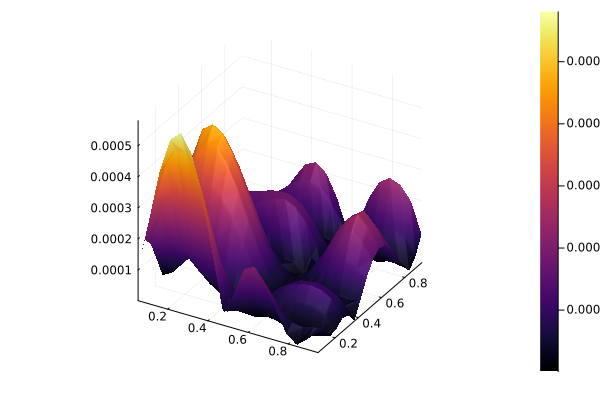

In [111]:
reference_v = vcat(true_v1.(I_points[1,:],I_points[2,:]),true_v2.(I_points[1,:],I_points[2,:]))

#N_I*2
#cond(Matrix(G))
A_global = sparse(A_global)
println(reference_v)
sol = A_global\G_RHS
err = abs.(sol - reference_v)
println("max error: ",maximum(err))
#surface(I_points[1,:],I_points[2,:],reference_v[1:N_I])
#surface(I_points[1,:],I_points[2,:],sol[1:N_I])
surface(I_points[1,:],I_points[2,:],err[1:N_I])